<a href="https://colab.research.google.com/github/gabrielatoniolo/dab-dbt-repository/blob/main/Monitoring_analyst_test%20-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CloudWalk - Monitoring Analyst Test**


Steps


*   Data exploration in SQL on BigQuery
*   Graph plotation on Python
*   Data encrichment on Pyton
*   ChatGPT help on Python code



# **First task**
Analysis of anomaly behevior in number of sales of POS

**STEP 1 - Data exploration in SQL**

---
Calculate the percentage of growth in the number of sales compared to last month and today.

```
SELECT
  *,
  round((today-avg_last_month)/avg_last_month,2) as growth,
FROM
  `checkout-2`
```




**STEP 2 - Graph plotation in python**

---
CSV data to a DATAFRAME


In [175]:
#import pandas library
import pandas as pd

In [176]:
#read csv file and save in anomaly
anomaly1 = pd.read_csv("anomaly_checkout_1.csv")

In [177]:
#read csv file and save in anomaly
anomaly = pd.read_csv("anomaly_checkout_2.csv")

Plot data in combo chart

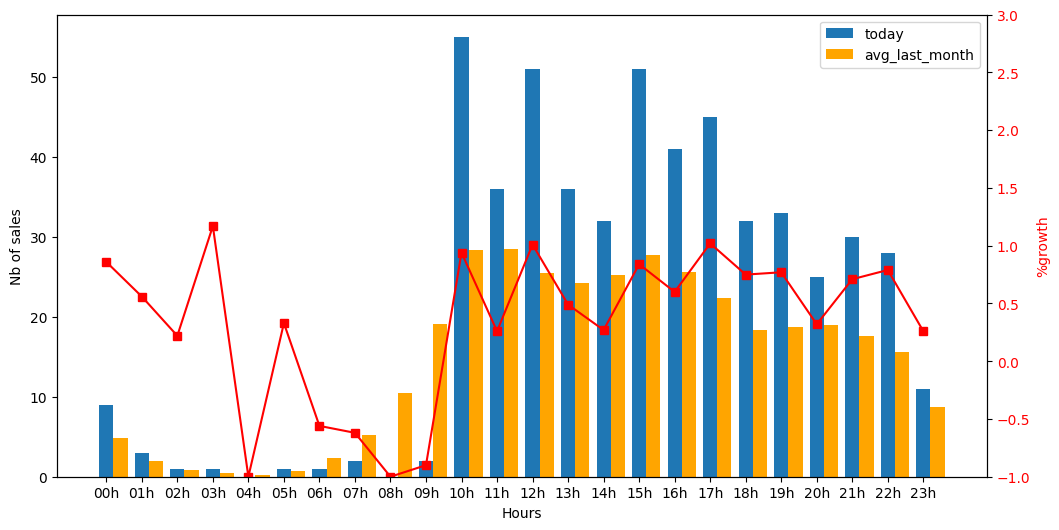

In [178]:
#import graphs library
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Hours')
ax1.set_ylabel('Nb of sales')
ax1.bar(anomaly1['time'],anomaly1['today'],width=0.4, label='today')
#second bar
x = [i + 0.4 for i, _ in enumerate(anomaly['time'])]
ax1.bar(x, anomaly1['avg_last_month'], width=0.4, label='avg_last_month', color='orange')


ax2= ax1.twinx() #set for same axis x
ax2.set_ylabel("%growth",color = 'red')
ax2.plot(anomaly1['time'],anomaly1['growth'],marker = 's',markersize = 6, color = 'red')
ax2.tick_params(axis='y',labelcolor = 'red')
ax2.set_ylim([-1,3])

ax1.legend()

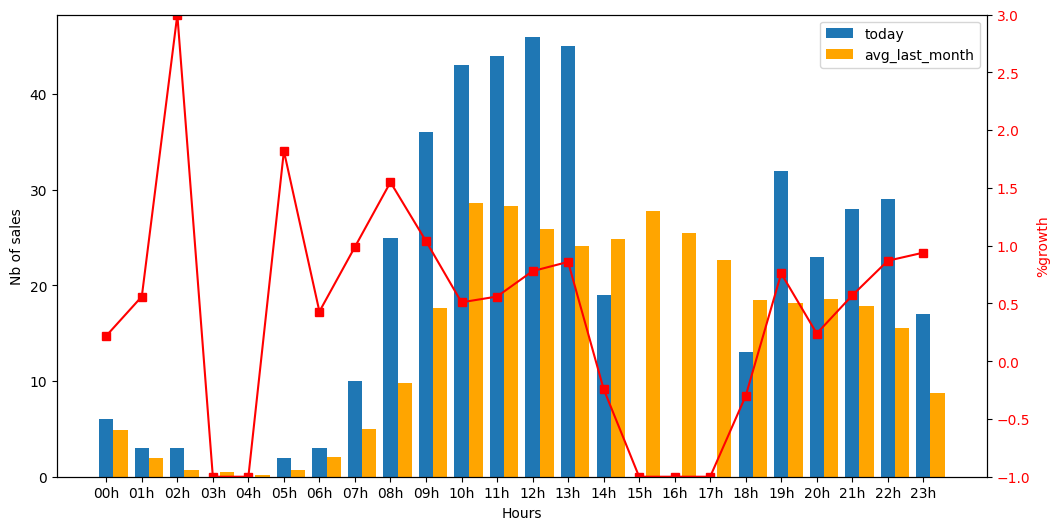

In [179]:
#import graphs library
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Hours')
ax1.set_ylabel('Nb of sales')
ax1.bar(anomaly['time'],anomaly['today'],width=0.4, label='today')
#second bar
x = [i + 0.4 for i, _ in enumerate(anomaly['time'])]
ax1.bar(x, anomaly['avg_last_month'], width=0.4, label='avg_last_month', color='orange')


ax2= ax1.twinx() #set for same axis x
ax2.set_ylabel("%growth",color = 'red')
ax2.plot(anomaly['time'],anomaly['growth'],marker = 's',markersize = 6, color = 'red')
ax2.tick_params(axis='y',labelcolor = 'red')
ax2.set_ylim([-1,3])

ax1.legend()

**STEP 3 - Anomaly Classification**

---
Classify the anomalies in two cases:    

1.   Anomaly 1 - When data is missing.
2.   Anomaly 2 - When there is an outlier number

```
SELECT
  *,
  CASE
  WHEN (today=0 or yesterday=0) and avg_last_month<1 THEN '-'
  WHEN today=0 and avg_last_month>10 THEN 'Anomaly1'
  WHEN per_today>1 and avg_last_month>6 THEN 'Anomaly2'
  ELSE '-'
  END as status
FROM
  `checkout-2`
```


**Case 1**

---

Probably a bug because there are no inputs.

In [180]:
bug1 = anomaly1[(anomaly1["status"]=='Anomaly1')]
bug1

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,growth,status
8,08h,0,1,18,8.71,10.42,-1.0,Anomaly1


In [181]:
bug = anomaly[(anomaly["status"]=='Anomaly1')]
bug

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,growth,status
15,15h,0,51,42,22.427,27.78,-1.0,Anomaly1
16,16h,0,41,36,21.570,25.53,-1.0,Anomaly1
17,17h,0,45,19,17.710,22.67,-1.0,Anomaly1


**Case 2**

---

An overflow anomaly, which could be an error or a seasonality.

In [182]:
overfloat1 = anomaly1[(anomaly1["status"]=='Anomaly2')]
overfloat1

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,growth,status
12,12h,51,39,39,27.57,25.42,1.01,Anomaly2
17,17h,45,30,29,20.42,22.28,1.02,Anomaly2


In [183]:
overfloat = anomaly[(anomaly["status"]=='Anomaly2')]
overfloat

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,growth,status
8,08h,25,0,12,3.71,9.82,1.55,Anomaly2
9,09h,36,2,27,10.14,17.64,1.04,Anomaly2


# **Second task**

Monitoring with real time alert with notifications to teams.


*   Recomedantion to 'alert' the anomalies found
*   Query to organize the data on the data
*   A graphic to see the data in real time
*   A model to determine anomalies

- rule-based : define the rules
- Score-base : create a model ML to score the transaciton and make a decision
- Combination of both


---
Alarts required
- if it's `failed` - with problem
- if it's `reversed` - with problem
- if it's `denied`- risk or issuer




**STEP 1 - Data exploration on python**

---
Analyze the number of errors over time.


In [184]:
t1 = pd.read_csv('transactions_1.csv') #create a dataframe to save the informartion from transactions_1
t1

,time,status,f0_
0,00h 00,approved,9
1,00h 00,denied,6
2,00h 00,refunded,1
3,00h 01,denied,8
4,00h 01,approved,13
...,...,...,...
4229,23h 59,processing,4
4230,23h 59,denied,1
4231,23h 59,backend_reversed,5
4232,23h 59,approved,10


Filter When is `denied` or `reversed` or `failed`

In [185]:
import numpy as np
import seaborn as sns
color_pal = sns.color_palette()

Functions to use

In [186]:
def graph (filter,df,column):
  select = df["status"] == filter #filter for each type of error
  df = df[(select)] #select only the data for that type of error
  df = df.reset_index(drop=True)
  df_new = df[['time',column]] #show only the columns of time and nb of transactions
  df_new = df_new.set_index("time") #set time as index
  df_new.plot(style = '.',figsize=(15,5),color = color_pal[0]) #plot the graph
  plt.show()
  return df

Denied - Error

---



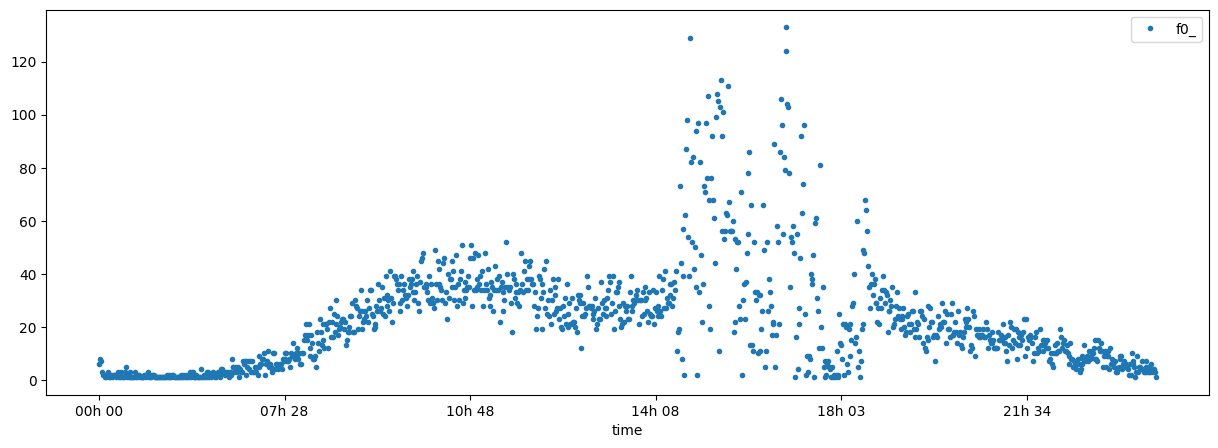

In [187]:
denied = t1
denied = graph('denied',denied,'f0_')

Reversed - Error

---



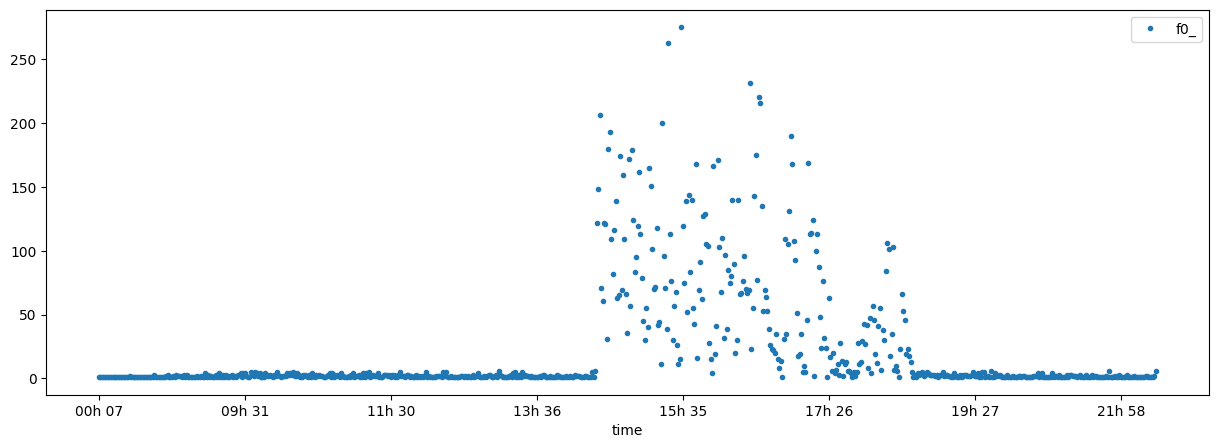

In [188]:
reversed = t1
reversed = graph('reversed',reversed,'f0_')

Failed - Error

---



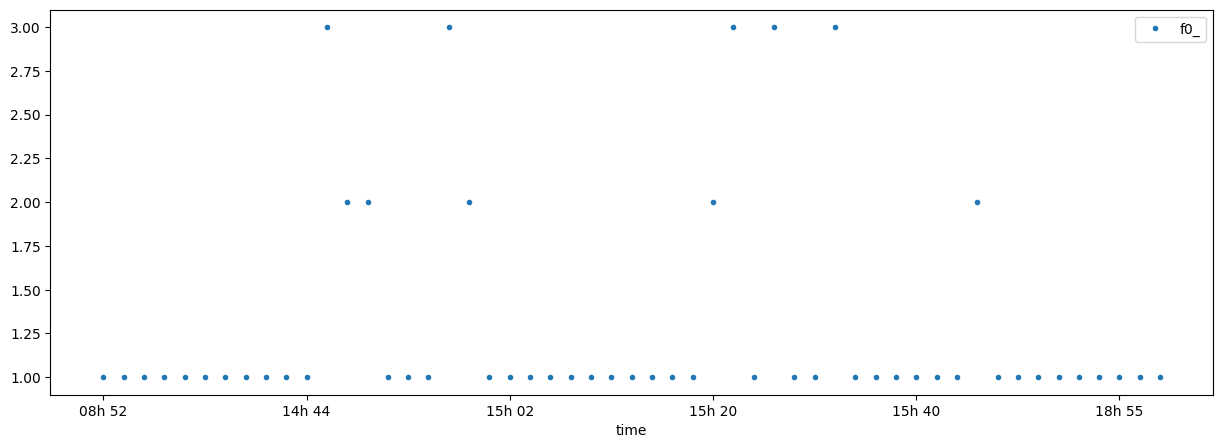

In [189]:
failed = t1
failed = graph('failed',failed,'f0_')

Rule Based - model to predict error


---
In a column it's save a variable as *alarm* when there ir a growth in ther number of cases compared to last 5 minutes or if it's bigger then the mean in 7 cases


In [190]:
def rule_based (column,df):
  df["alarm"] = ""
  mean = df[column].mean()

  #Classify the anomaly as an alarm
  last = df[column].iloc[0:5]
  med = np.mean(last.values)
  u = 0
  for i in df[column]:
    a = df[column].get(u) #get the value of f0_
    if (a > med and a > mean): #verify if the value is bigger then the list o previus 5 numbers or bigger then the mean
      df.loc[u,"alarm"] = "alarm-1"
    if a > mean+7:
      df.loc[u,"alarm"] = "alarm-2"
    u+=1
    last = df[column].iloc[u-1:u+4]
    med = np.mean(last.values)
  return df

In [191]:
denied = rule_based("f0_",denied)

denied[(denied["alarm"]== "alarm-1") | (denied["alarm"]== "alarm-2") ]

,time,status,f0_,alarm
238,08h 06,denied,23,alarm-1
249,08h 17,denied,27,alarm-1
253,08h 21,denied,25,alarm-1
256,08h 24,denied,30,alarm-2
257,08h 25,denied,24,alarm-1
...,...,...,...,...
937,20h 31,denied,23,alarm-1
942,20h 36,denied,26,alarm-1
943,20h 37,denied,24,alarm-1
997,21h 31,denied,23,alarm-1


In [192]:
reversed = rule_based("f0_",reversed)

reversed[(reversed["alarm"]== "alarm-1") | (reversed["alarm"]== "alarm-2") ]

,time,status,f0_,alarm
341,14h 33,reversed,122,alarm-2
342,14h 34,reversed,148,alarm-2
343,14h 35,reversed,206,alarm-2
344,14h 36,reversed,71,alarm-2
345,14h 37,reversed,61,alarm-2
...,...,...,...,...
544,18h 24,reversed,103,alarm-2
550,18h 36,reversed,66,alarm-2
551,18h 37,reversed,53,alarm-2
552,18h 38,reversed,46,alarm-2


In [193]:
failed = rule_based("f0_",failed)

failed[(failed["alarm"]== "alarm-1") | (failed["alarm"]== "alarm-2") ]

,time,status,f0_,alarm
11,14h 46,failed,3,alarm-1
12,14h 49,failed,2,alarm-1
13,14h 50,failed,2,alarm-1
17,14h 56,failed,3,alarm-1
18,14h 57,failed,2,alarm-1
31,15h 21,failed,3,alarm-1
33,15h 24,failed,3,alarm-1
36,15h 29,failed,3,alarm-1
43,16h 16,failed,2,alarm-1


**Message Alert**

---



In [194]:
import smtplib
from email.message import EmailMessage

In [195]:
def email_alert(subject,body,to):
  msg = EmailMessage()
  msg.set_content(body)
  msg['subject'] = subject
  msg['to'] = to

  user = "gabrielatoniolob@gmail.com"
  msg['from'] = user
  password = "rekbijqbnbmmwsjw"

  server = smtplib.SMTP('smtp.gmail.com', 587)
  server.starttls()
  server.login(user,password)
  server.send_message(msg)

  server.quit()

if __name__ == '__main__':
  subject = "Hey"
  body = "Hello World"
  to = "gabrielatonio@hotmail.com"
  email_alert(subject,body,to)

In [215]:
test = denied[(denied["alarm"]== "alarm-1") | (denied["alarm"]== "alarm-2") ]
test

,time,status,f0_,alarm
238,08h 06,denied,23,alarm-1
249,08h 17,denied,27,alarm-1
253,08h 21,denied,25,alarm-1
256,08h 24,denied,30,alarm-2
257,08h 25,denied,24,alarm-1
...,...,...,...,...
937,20h 31,denied,23,alarm-1
942,20h 36,denied,26,alarm-1
943,20h 37,denied,24,alarm-1
997,21h 31,denied,23,alarm-1


In [282]:
test = denied[(denied["alarm"]== "alarm-1") | (denied["alarm"]== "alarm-2") ]
test = test.iloc[60:80]
test = test.reset_index(drop=True)
test["min"] = test["time"]
test["min"] = test["min"].str.split('h ').str[0].astype(int) * 60 + test["min"].str.split('h ').str[1].astype(int)
test

,time,status,f0_,alarm,min
0,10h 00,denied,35,alarm-2,600
1,10h 01,denied,36,alarm-2,601
2,10h 02,denied,33,alarm-2,602
3,10h 03,denied,30,alarm-2,603
4,10h 04,denied,39,alarm-2,604
5,10h 06,denied,36,alarm-2,606
6,10h 07,denied,31,alarm-2,607
7,10h 10,denied,49,alarm-2,610
8,10h 11,denied,36,alarm-2,611
9,10h 12,denied,30,alarm-2,612


In [289]:
test = denied
test = test.reset_index(drop=True)
test["min"] = test["time"]
test["min"] = test["min"].str.split('h ').str[0].astype(int) * 60 + test["min"].str.split('h ').str[1].astype(int)
test

,time,status,f0_,alarm,min
0,00h 00,denied,6,,0
1,00h 01,denied,8,,1
2,00h 02,denied,7,,2
3,00h 03,denied,3,,3
4,00h 05,denied,2,,5
...,...,...,...,...,...
1135,23h 55,denied,4,,1435
1136,23h 56,denied,3,,1436
1137,23h 57,denied,4,,1437
1138,23h 58,denied,3,,1438


In [295]:
txt = denied["status"].get(0)
txt

'denied'

In [328]:
def send_email (df,column,alarm):
  u = 0
  minutes = 0
  min = 0
  mean = df[column].mean()

  #create a column min to control the number of e-mail sent
  df = df.reset_index(drop=True)
  df["min"] = df["time"]
  df["min"] = df["min"].str.split('h ').str[0].astype(int) * 60 + df["min"].str.split('h ').str[1].astype(int)

  for i in df["alarm"]:
    nb = df[column].get(u)
    if i == alarm:
      subject = f'Error - ALERT - Number of {df["status"].get(0)} is getting high'

      if df["min"].get(u) > minutes+30: #send an alarm after 20min or if there was a increase of 70% in the number of cases
        minutes = df["min"].get(u)

        time = df["time"].get(u)
        body = f'Error at {time}'
        if test["f0_"].get(u) > mean*2.3:
          body = f"The number of errors is two times bigger than usual. Please verify why the number of transactions with status - {df['status'].get(0)} - is increasing. Time of error:{time} \nAtt. \nMonitoring team"
        print(body)
        #if __name__ == '__main__':
          #to = "gabrielatonio@hotmail.com"
          #email_alert(subject,body,to)

        print(f'e-mail enviado - hora {test["time"].get(u)} erro: {test["f0_"].get(u)}')
        print("--------")

      if df["min"].get(u) > min+20 and (nb > mean*2.3): #send an alarm after 20min or if there was a increase of 70% in the number of cases
        min = df["min"].get(u)

        time = df["time"].get(u)
        body = f"The number of errors is two times biiger than usual. Please verify why the number of transactions with status - {df['status'].get(0)} - is increasing. Time of error:{time} \nAtt. \nMonitoring team"
        print(body)
        #if __name__ == '__main__':
          #to = "gabrielatonio@hotmail.com"
          #email_alert(subject,body,to)
        print(f'e-mail enviado - hora {test["time"].get(u)} erro: {test["f0_"].get(u)}')
        print("--------")



    u+=1


In [329]:
send_email(denied,"f0_","alarm-2")

Error at 08h 24
e-mail enviado - hora 08h 24 erro: 30
--------
Error at 08h 57
e-mail enviado - hora 08h 57 erro: 30
--------
Error at 09h 28
e-mail enviado - hora 09h 28 erro: 38
--------
Error at 09h 59
e-mail enviado - hora 09h 59 erro: 35
--------
Error at 10h 30
e-mail enviado - hora 10h 30 erro: 41
--------
Error at 11h 01
e-mail enviado - hora 11h 01 erro: 41
--------
Error at 11h 34
e-mail enviado - hora 11h 34 erro: 40
--------
Error at 12h 05
e-mail enviado - hora 12h 05 erro: 36
--------
Error at 12h 38
e-mail enviado - hora 12h 38 erro: 31
--------
Error at 13h 09
e-mail enviado - hora 13h 09 erro: 37
--------
Error at 13h 40
e-mail enviado - hora 13h 40 erro: 33
--------
Error at 14h 12
e-mail enviado - hora 14h 12 erro: 39
--------
The number of errors is two times biiger than usual. Please verify why the number of transactions with status - denied - is increasing. Time of error:14h 35 
Att. 
Monitoring team
e-mail enviado - hora 14h 35 erro: 73
--------
The number of err

In [294]:
u = 0
minutes = 0
min = 0
mean = denied["f0_"].mean()

for i in test["alarm"]:
  nb = test["f0_"].get(u)
  if i == "alarm-2":
    subject = "Error - ALERT - Number of Denied to high"

    #if time > minutes+20:
    if test["min"].get(u) > minutes+20: #send an alarm after 20min or if there was a increase of 70% in the number of cases
      minutes = test["min"].get(u)

      time = test["time"].get(u)
      body = f'Error at {time}'
      #if __name__ == '__main__':
        #to = "gabrielatonio@hotmail.com"
        #email_alert(subject,body,to)

      print(f'e-mail enviado - hora {test["time"].get(u)} erro: {test["f0_"].get(u)}')


    if test["min"].get(u) > min+20 and (nb > mean*1.7): #send an alarm after 20min or if there was a increase of 70% in the number of cases
      min = test["min"].get(u)

      time = test["time"].get(u)
      body = f'Error at {time}'
      #if __name__ == '__main__':
        #to = "gabrielatonio@hotmail.com"
        #email_alert(subject,body,to)
      print(f'e-mail enviado - hora {test["time"].get(u)} erro: {test["f0_"].get(u)}')

  u+=1

e-mail enviado - hora 08h 24 erro: 30
e-mail enviado - hora 08h 50 erro: 34
e-mail enviado - hora 09h 13 erro: 35
e-mail enviado - hora 09h 17 erro: 39
e-mail enviado - hora 09h 34 erro: 39
e-mail enviado - hora 09h 46 erro: 41
e-mail enviado - hora 09h 55 erro: 45
e-mail enviado - hora 10h 10 erro: 49
e-mail enviado - hora 10h 16 erro: 35
e-mail enviado - hora 10h 33 erro: 47
e-mail enviado - hora 10h 37 erro: 38
e-mail enviado - hora 10h 57 erro: 47
e-mail enviado - hora 10h 58 erro: 36
e-mail enviado - hora 11h 19 erro: 39
e-mail enviado - hora 11h 19 erro: 39
e-mail enviado - hora 11h 40 erro: 33
e-mail enviado - hora 11h 43 erro: 48
e-mail enviado - hora 12h 02 erro: 39
e-mail enviado - hora 12h 08 erro: 42
e-mail enviado - hora 12h 23 erro: 38
e-mail enviado - hora 12h 44 erro: 32
e-mail enviado - hora 12h 54 erro: 39
e-mail enviado - hora 13h 09 erro: 37
e-mail enviado - hora 13h 18 erro: 39
e-mail enviado - hora 13h 40 erro: 33
e-mail enviado - hora 13h 41 erro: 39
e-mail envia

In [213]:
u = 0
control = 0
for i in test["alarm"]:
  nb = test["f0_"].get(u)
  if i == "alarm-1":

      subject = "Error - Growning the number of Denied"
      time = test["time"].get(u)
      body = f'Error at {time}'
      if __name__ == '__main__':
        to = "gabrielatonio@hotmail.com"
        email_alert(subject,body,to)


  if i == "alarm-2":
    if nb > control+15:
      subject = "Error - ALERT - Number of Denied to high"
      time = test["time"].get(u)
      body = f'Error at {time}'
      if __name__ == '__main__':
        to = "gabrielatonio@hotmail.com"
        email_alert(subject,body,to)
    control = test["f0_"].get(u)
  u+=1

# **Model**

**Install mode to execute XGBoost model**

This model didn't work so well to estimate the future values.

In [198]:
import xgboost as xgb

Types of series data

In [207]:
t1_denied.index

Index(['00:00', '00:01', '00:02', '00:03', '00:05', '00:06', '00:07', '00:08',
       '00:10', '00:11',
       ...
       '23:44', '23:45', '23:46', '23:53', '23:54', '23:55', '23:56', '23:57',
       '23:58', '23:59'],
      dtype='object', name='time', length=1140)

In [201]:
t1_denied.index = pd.to_datetime(t1_denied.index, format='%Hh %M') # transforme time to datetype
t1_denied.index = t1_denied.index.strftime('%H:%M')

ValueError: ignored

In [ ]:
t1_denied

Train/Test Split

In [ ]:
train = t1_denied.loc[t1_denied.index < '14:00'] #separate the values before 16h
test = t1_denied.loc[t1_denied.index >= '14:00'] #separate the values after 16h

#make a plot with subplots
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train.index,train['f0_'], color = 'red')
ax.plot(test.index,test['f0_'], label = "test")
ax.axvline('14:00',color ='black',ls="--")
ax.legend(["Train Set","Test Set"])

# Ajuste o intervalo (2 horas) conforme necessário
ax.set_xticks(test.index[::60],minor = False)
plt.show()

Create our Model

In [ ]:
t1_denied["hour"] = t1_denied.index
t1_denied

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def minutes (df):
  df["min"] = df.index
  df["min"] = df["min"].str.split(':').str[0].astype(int) * 60 + df["min"].str.split(':').str[1].astype(int)
  return df

train = minutes(train)
test = minutes(test)

TARGET = "f0_"
FEATURES = "min"

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
        verbose=20)

Forcast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)

In [ ]:
t1_denied

In [ ]:
t1_denied = t1_denied.merge(test[['prediction']],how = 'left', left_index = True, right_index= True)

ax = t1_denied[["f0_"]].plot(figsize =(15,5))
t1_denied['prediction'].plot(ax=ax, style='.')
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Dat and Prediciton")
plt.show()